/home/ahabis/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahabis/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


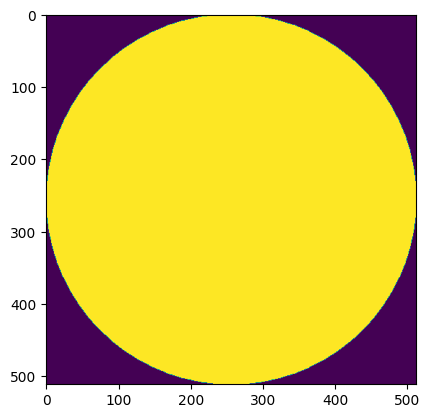

In [1]:
from unsupervised_dac import DAC
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

filename = "flower0.jpg"
img = plt.imread(os.path.join("images_test_unsupervised_dac", filename))
img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)

shape = img.shape[:-1]
def define_contour_init(img):
    center = np.flip(np.array(shape)) // 2
    axes = center  # major, minor axes
    angle = 0
    start_angle = 0
    end_angle = 360
    color = 1
    thickness = -1

    # Draw a filled ellipse on the input image
    mask = cv2.ellipse(
        np.zeros(img.shape[:-1]),
        center,
        axes,
        angle,
        start_angle,
        end_angle,
        color,
        thickness,
    ).astype(np.uint8)
    contour = np.squeeze(
        cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0]
    )
    return contour, mask


contour_init, mask = define_contour_init(img)
plt.imshow(mask)

In [2]:
from skimage.measure import label
import cv2
from scipy.ndimage import binary_closing, binary_opening, binary_dilation, binary_erosion
from skimage.morphology import disk
from scipy.ndimage.morphology import distance_transform_edt
# print(contour_init/512)


/tmp/ipykernel_218132/2575076023.py:5: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [3]:
# def delete_loops(contour,
#                  shape):
    
#     contour = (contour*shape).astype(int)
#     zeros = np.zeros(shape)
#     new_img = cv2.fillPoly(zeros,[contour],1)
#     new_img = binary_opening(new_img,disk(2))
#     label_=  label(new_img,connectivity=1)
#     uniques, counts = np.unique(label_,
#                                 return_counts = True)
#     biggest = uniques[np.argsort(counts)]
#     biggest = biggest[biggest!=0][-1]
#     contour = np.squeeze(cv2.findContours((label_ == biggest).astype(int), 
#                 method = cv2.RETR_TREE,
#                 mode=cv2.CHAIN_APPROX_SIMPLE,
#                 )[0][0])/shape
    
#     return contour

In [4]:
# contour_init = delete_loops(contour_init/512,(512,512))
# print(contour_init.shape)
# plt.plot(contour_init[:,0], contour_init[:,1])

In [12]:
dac = DAC(nb_points = 100,
          n_epochs = 300,
          learning_rate = 1e-1,
          clip = 1e-1,
          exponential_decay = 1.,
          thresh = 1e-5)

In [13]:
contour, energy = dac.predict(img,contour_init)

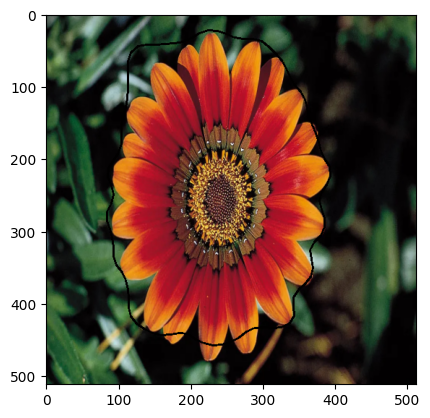

In [14]:
shape_to_display = (np.expand_dims(contour[-1], 1)).astype(int)
new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                        [shape_to_display],
                        0,
                        color = 1,
                        thickness=2)
plt.imshow(new_img)
plt.show()

In [58]:
def delete_loops(contour,
                 shape):
    
    contour = (contour*shape).astype(int)
    zeros = np.zeros(shape)
    new_img = cv2.fillPoly(zeros,[contour],1)
    new_img = binary_erosion(new_img,disk(1))
    label_=  label(new_img)

    uniques, counts = np.unique(label_,
                                return_counts = True)
    biggest = uniques[np.argsort(counts)]
    biggest = biggest[biggest!=0][-1]
    dilation  = binary_dilation((label_ == biggest),disk(1)).astype(int)
    contour = np.squeeze(cv2.findContours(dilation, 
                method = cv2.RETR_TREE,
                mode=cv2.CHAIN_APPROX_SIMPLE,
                )[0][0])/shape
    
    return contour

In [59]:
contour_without_loop = delete_loops(contour[-1]/512,(512,512))


In [37]:
ener = np.squeeze(energies.cpu().detach().numpy())                                                
isolines = dac.ss.cpu().detach().numpy()

for scale in range(4):
    for index, isoline in enumerate(isolines):
        
        plt.plot(np.arange(dac.n_epochs),ener[:,scale,index],label = 'isoline '+str(isoline))
    plt.title('evolution of the energies at scale: ' +str(scale+1))
    plt.xlabel('step')
    plt.ylabel('energie value')
    plt.legend()
    plt.show()

NameError: name 'energies' is not defined

In [ ]:
fig = plt.figure()

cmap = matplotlib.cm.get_cmap('seismic')

colors = [cmap(u)[:-1] for u in np.linspace(0,1,dac.n_epochs+1)]
colors = (np.array(colors)*255).astype(np.int32).tolist()



tots = []
imgs = []

for i, shape in enumerate(shape_fin[y]):

    shape_to_display = (np.expand_dims(shape, 1)).astype(int)
    
    new_img = cv2.drawContours((((img/np.max(img))*255).astype(np.uint8)).copy(),
                               [shape_to_display],
                               0,
                               color = colors[i],
                               thickness=1)
    im = plt.imshow(new_img.astype(np.uint8), animated=True)
    
    imgs.append([im])
    
ani = animation.ArtistAnimation(fig, 
                                imgs,
                                interval=50,
                                blit=False,
                                repeat_delay=1000)
plt.show()